Epoch 1/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8715 - loss: 1.0292 - val_accuracy: 0.9410 - val_loss: 0.2326 - learning_rate: 0.0030
Epoch 2/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9331 - loss: 0.2496 - val_accuracy: 0.9447 - val_loss: 0.2201 - learning_rate: 0.0030
Epoch 3/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9391 - loss: 0.2252 - val_accuracy: 0.9485 - val_loss: 0.2045 - learning_rate: 0.0030
Epoch 4/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9422 - loss: 0.2103 - val_accuracy: 0.9526 - val_loss: 0.1807 - learning_rate: 0.0030
Epoch 5/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9494 - loss: 0.1774 - val_accuracy: 0.9504 - val_loss: 0.1668 - learning_rate: 0.0024
Epoch 6/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9510 - loss: 0.1647 - val_accuracy: 0.9571 - val_loss: 0.1504 - learning_rate: 0.0019
Epoch 7/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9541 - loss: 0.1

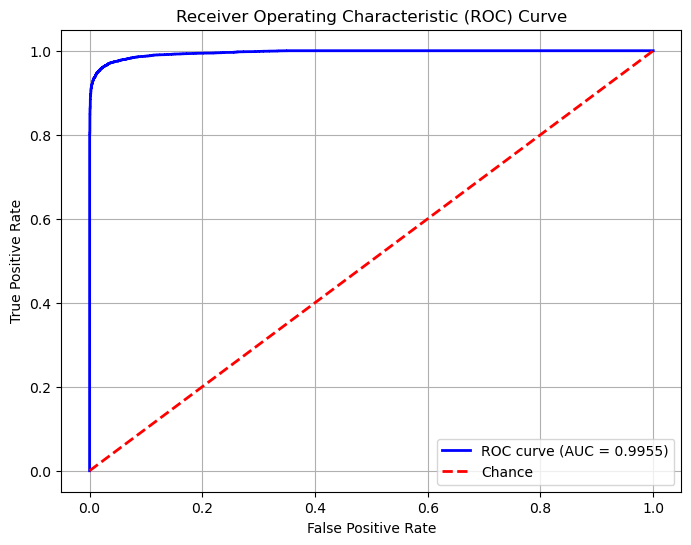

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Load the dataset
data = pd.read_csv('UNSW_NB15.csv')

# Drop irrelevant features
data = data.drop(['id', 'attack_cat'], axis=1)

# Separate features and labels
X = data.drop('label', axis=1)
y = data['label']

# Convert categorical features to numeric
categorical_columns = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_columns:
    X[col] = le.fit_transform(X[col])

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape input data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(X_train.shape[1], 1)))

# Convolutional layers with Batch Normalization
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten for dense layers
model.add(layers.Flatten())

# Fully connected layers with Dropout and L2 Regularization
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.6))  # Increased dropout

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))  # Increased dropout

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.003)  # Slightly higher learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Learning Rate Scheduler
def lr_schedule(epoch, lr):
    if epoch > 3:  # Decay starts earlier
        return lr * 0.8  # Stronger decay
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with validation split
history = model.fit(
    X_train, y_train, 
    epochs=50,  # Reduced epochs
    batch_size=64,  # Smaller batch size
    validation_split=0.2, 
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

# ROC Curve and AUC
y_pred_prob = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
